# Modélisation des incertitude, mécanique probabiliste 2021-2022

## Final Project

### Outline

The final project consists into _conceive_ and _train_ an efficient metamodel to predict the mechanical behaviour of the ten-bar truss problem [1]

![Truss structure](truss_structure.png)

The mechanical properties of the ten-bar truss problems are affected by high uncertainty. In particular, a few key parameters have to be considered in this project[1]:


![Table of random mechanical properties [1].](table_truss_random.png)

where :

- $A_1$: the cross-section areas of the horizontal members
- $A_2$: the cross-section areas of the vertical members 
- $A_3$: the cross-section areas of the diagonal members
- $E$: Young's Modulus
- $L$: truss lengths
- $P$: load acting at the joints

The __quantity of interest__ (__QoI__) is the tip displacement $d$ and the allowable displacement at node 2, whose theoretical expression reads (Equation 1):

$$d = \frac{PL}{A_1 A_3 E D_T}\left[4 \sqrt{2}A_1^3 \left(24 A_2^2 + A_3^2 \right)+A_3^3 \left(7 A_1^2 + 26 A_2^2 \right)+4 A_1 A_2 A_3 \left\lbrace \left( 20 A_1^2 + 76 A_1 A_2 + 10 A_3^2 \right) + \sqrt{2} A_3 \left( 25 A_1 + 29 A_2 \right) \right\rbrace\right]$$

where: $$D_T = 4 A_2^2 \left( 8 A_1^2 + A_3^2 \right) + 4 \sqrt{2} A_1 A_2 A_3 \left( 3 A_1 + 4 A_2 \right) + A_1 A_3^2 \left( A_1 + 6 A_2 \right)$$

The reliability is evaluated for __Limit State Function__
with respect to the displacement at node 2 as following:



$$g = d_{allow}-d$$


with the following allowed displacement values:

__Table 2__

![Table of allowed maximum displacement at node 2 [1].](dallow.png)

## Task 1 - Generate the dataset [T1]

Considering Table 1, perform a __Design of Experiment (DoE)__ by producing a __Learning DataBase (LDB)__ for suitable metamodelling. To this end, use the [__Direct MonteCarlo Simulation technique (DMCS)__](https://en.wikipedia.org/wiki/Direct_simulation_Monte_Carlo) by considering the following alternative scenarios:

- T1.1 the variables in Table 1 are all independent random variables (__LDB1__)
- T1.2 the variables in Table 1 are all independent but two $A_1$, $L$, with correlation coefficients $R_{A_1,L}$=0.2  (__LDB2__)

- __Hint 1:__ For this task, you can neglect inertial effects and consider the problem as quasi-static

- __Hint 2:__ Generate independent normal random variables $\mathcal{N}(\mathbf{0},\mathbf{I})$

- __Hint 3:__ Assemble the correlation matrix $\mathbf{R}$

- __Hint 4:__ Compute the diagonal correlation matrix and associated eigenvectors 

- __Hint 5:__ Assemble the correlated Gaussian random field

- __Hint 6:__ If the random field follows a non-gaussian marginal probability distribution, use the Rosenblatt transform

In [57]:
# Import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def Xc_gen(p, cor = False, alpha = 0.95):

    # Set the mean and standard deviation of the underlying normal distribution
    mu_A1 = 7.5e-3
    mu_A2 = 1.5e-3
    mu_A3 = 5.0e-3
    mu_E = 70
    mu_L = 9
    mu_P = 350
    sigma_A1 = 0.1
    sigma_A2 = 0.1
    sigma_A3 = 0.1
    sigma_E = 0.05
    sigma_L = 0.05
    sigma_P = 0.1

    # LogNormal
    mu = np.array([mu_A1, mu_L, mu_A2, mu_A3, mu_E])
    n = mu.shape[0]
    sigma = np.array([sigma_A1, sigma_L, sigma_A2, sigma_A3, sigma_E])
    sigmaln = np.log(1+(sigma**2))
    sigmalnd = np.diag(sigmaln)

    mus = np.log(mu) - 0.5*(sigmaln)
    mud = np.vstack([mus]*p).T

    # Gumbell
    mug = np.array([mu_P]).T
    ng = mug.shape[0]
    sigmag = np.array([sigma_P*mu_P])
    alphas = (6**0.5)*sigmag/np.pi
    s0 = mug - 0.577216*alphas
    # Set the size of the sample
    
    # Generate the sample
    #sample = np.random.lognormal(mu, sigma, size)

    S = np.random.normal(0,1,(n,p))
    if cor == True:
        rho = 0.2
        R = np.array([[1, rho], [rho, 1]])
        eigval, eigvec = np.linalg.eig(R)
        S[0:2, :] = eigvec@np.sqrt(np.diag(eigval))@S[0:2,:]

    Ug = np.random.uniform(0,1,(ng,p))
    Sgs = s0 - alphas * np.log(-np.log(Ug))

    X = np.exp(np.sqrt(sigmalnd)@S + mud)

    # Print the sample
    Xc = np.vstack((X, Sgs))
    [A_1, L, A_2, A_3, E, P] = Xc
    d = dtest(Xc)
    g = limit(d, 0.1)
    test = g <= 0
    test = test.astype(int)
    dat = test.copy()
    m_d = 1/p * np.sum(d)
    s_d = np.sqrt(1/p * np.sum((d-m_d)**2))
    pf = 1/p * np.sum(dat)
    #m_low, m_up, s_low, s_up = confidence_interval(m_d, s_d, alpha, p)
    return Xc, pf, m_d, s_d, d

Xc, pf, m_d, s_d, d = Xc_gen(10)

In [2]:
def D_T(X):
    [A_1, L, A_2, A_3, E, P] = X
    E = E*1e9
    P = P*1e3
    Dt = 4*(A_2**2)*((8*A_1**2) + (A_3**2)) + 4*2**0.5*A_1*A_2*A_3*(3*A_1 + 4*A_2) + A_1*A_3**2*(A_1 + 6*A_2)
    return Dt
def dtest(X):
    [A_1, L, A_2, A_3, E, P] = X
    E = E*1e9
    P = P*1e3
    d = P*L/(A_1*A_3*E*D_T(X))*(4*2**0.5*A_1**3 * (24*A_2**2 + A_3**2)+A_3**3*(7*A_1**2 + 26*A_2**2)+4*A_1*A_2*A_3*((20*A_1**2 + 76*A_1*A_2 + 10*A_3**2) + 2**0.5*A_3*(25*A_1 + 29*A_2)))
    return d

def limit(d, dallow):
    return dallow - d

def confidence_interval(m, s, alpha, N) :
    # Interval for mean
    t_low = stats.t.cdf(1-alpha/2, N-1)
    t_up = stats.t.cdf(1-alpha/2, N+1)
    m_low = m - t_low * s/np.sqrt(N)
    m_up = m + t_up * s/np.sqrt(N)
    
    # Interval for standard deviation
    chi_low = stats.chi2.cdf(1-alpha/2, N-1)
    chi_up = stats.chi2.cdf(alpha/2, N-1)
    s_low = np.sqrt((N-1)*s**2/chi_low**2)
    s_up = np.sqrt((N-1)*s**2/chi_up**2)  

    return m_low, m_up, s_low, s_up

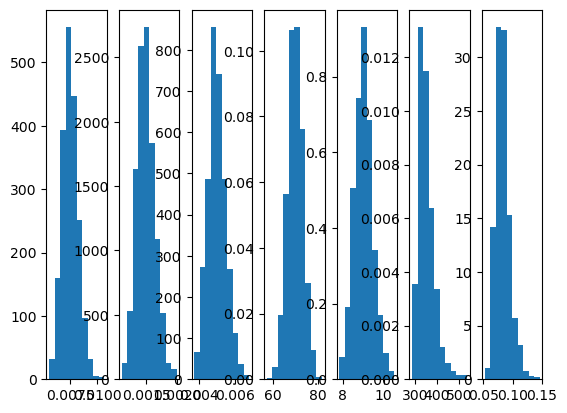

0.08317043183973781
0.012333906420068059


In [46]:
[A_1, L, A_2, A_3, E, P] = Xc
plt.figure(2)
plt.subplot(1,7,1)
plt.hist(A_1,  density = True)
plt.subplot(1,7,2)
plt.hist(A_2,  density = True)
plt.subplot(1,7,3)
plt.hist(A_3,  density = True)
plt.subplot(1,7,4)
plt.hist(E, density = True)
plt.subplot(1,7,5)
plt.hist(L, density = True)
plt.subplot(1,7,6)
plt.hist(P, density = True)
plt.subplot(1,7,7)
plt.hist(d, density = True)
plt.show()
print(m_d)
print(s_d)

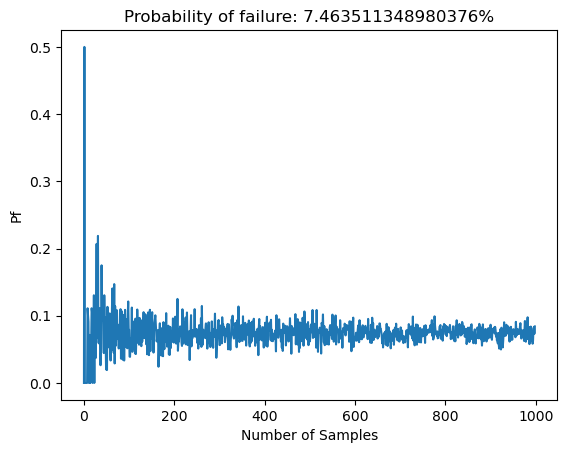

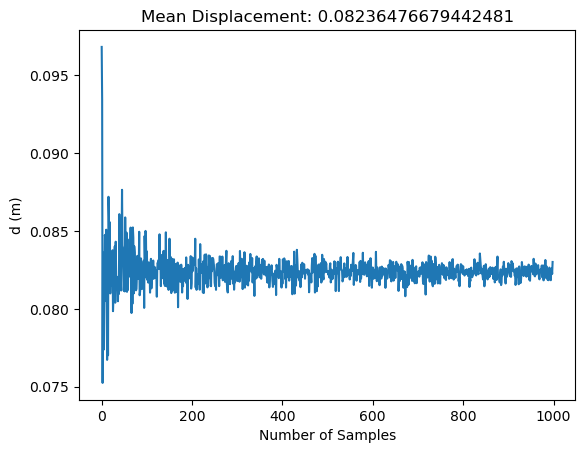

In [7]:
Np = 1000
N = np.arange(1, Np, 1)
pfA = np.zeros(N.shape)
m_dA = np.zeros(N.shape)
for i in range(len(N)):
    Xc, xpf, m_d, s_d, d = Xc_gen(N[i], cor=False)
    pfA[i] = xpf
    m_dA[i] = m_d
    
plt.plot(pfA)
pfAm = np.mean(pfA[int(Np/2):Np])
plt.title('Probability of failure: {}%'.format(pfAm*100))
plt.xlabel('Number of Samples')
plt.ylabel('Pf')

plt.show()
plt.plot(m_dA)
plt.title('Mean Displacement: {}'.format(np.mean(m_dA[int(Np/2):Np])))
plt.xlabel('Number of Samples')
plt.ylabel('d (m)')
plt.show()
print()

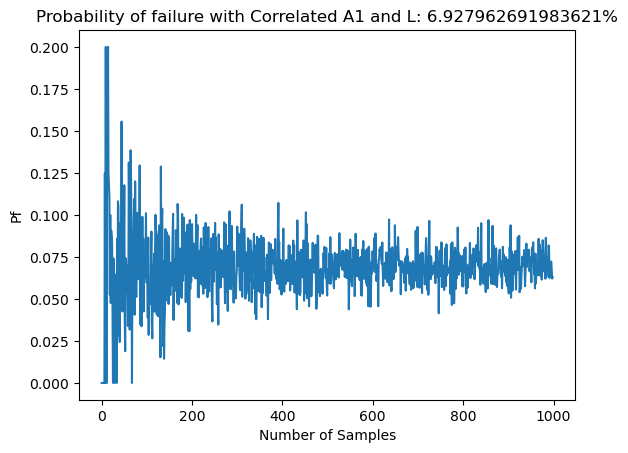

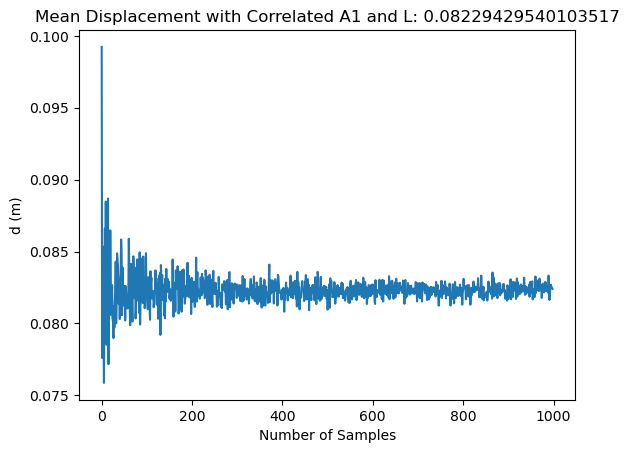

In [9]:
Np = 1000
N = np.arange(1, Np, 1)
pfA = np.zeros(N.shape)
m_dA = np.zeros(N.shape)
for i in range(len(N)):
    Xc, xpf, m_d, s_d, d = Xc_gen(N[i], cor=True)
    pfA[i] = xpf
    m_dA[i] = m_d
    
plt.plot(pfA)
pfAm = np.mean(pfA[int(Np/2):Np])
plt.title('Probability of failure with Correlated A1 and L: {}%'.format(pfAm*100))
plt.xlabel('Number of Samples')
plt.ylabel('Pf')

plt.show()
plt.plot(m_dA)
plt.title('Mean Displacement with Correlated A1 and L: {}'.format(np.mean(m_dA[int(Np/2):Np])))
plt.xlabel('Number of Samples')
plt.ylabel('d (m)')
plt.show()
print()

In [240]:
N_max = 50
step = 1
correlated = False

#d_allow = [0.1, 0.105, 0.11, 0.115, 0.12]
d_allow = [0.12]
Legend = ['{} m'.format(d_al) for d_al in d_allow]
plot_dict = {}

for d_al in d_allow :
    plot_dict[d_al] = [[],[],[],[],[],[],[]]
    for N in range(step,N_max,step) :
        p_hat_f, m_d, s_d, m_low, m_up, s_low, s_up = probability_of_failure(N, correlated, d_al, 0.90)
        plot_dict[d_al][0].append(p_hat_f)
        plot_dict[d_al][1].append(m_low)
        plot_dict[d_al][2].append(m_d)
        plot_dict[d_al][3].append(m_up)
        plot_dict[d_al][4].append(s_low)
        plot_dict[d_al][5].append(s_d)
        plot_dict[d_al][6].append(s_up)
    plt.figure(1)
    plt.plot(range(step,N_max,step), plot_dict[d_al][0],'-k')
    plt.ylabel('Probability of failure')
    plt.figure(2)
    plt.plot(range(step,N_max,step), plot_dict[d_al][1],'--g')
    plt.plot(range(step,N_max,step), plot_dict[d_al][2],'-k')
    plt.plot(range(step,N_max,step), plot_dict[d_al][3],'--g')
    plt.ylabel('Statistical mean')
    plt.figure(3)
    plt.plot(range(step,N_max,step), plot_dict[d_al][4],'--g')
    plt.plot(range(step,N_max,step), plot_dict[d_al][5],'-k')
    plt.plot(range(step,N_max,step), plot_dict[d_al][6],'--g')
    plt.ylabel('Statistical standard deviation')

for i in range(1,4) :
    plt.figure(i)
    #plt.legend(Legend)
    plt.title('Correlated A1 and L: '+str(correlated))
    plt.xlabel('Number of samples N')def probability_of_failure(N, correlated, d_allow, alpha) :

    ## Variables A1, L, A2, A3, E
    n = 5

    # parameters of the lognormal distributions
    lambda_S = np.vstack([lambda_S_init]*N).T
    ksi_S = np.eye(n) * ksi_S_init

    # Lognormal distributions
    S = np.random.normal(loc=0.0, scale=1.0, size=(n,N))

    if correlated :
        # Matrix of correlation
        R = np.array([[1, 0.2], [0.2, 1]])
        w, T = np.linalg.eig(R)
        Lambda = np.diag(w)
        S[0:2,:] = T @ Lambda @ S[0:2,:]
        
    X = np.zeros((n,N))
    X = np.exp(np.sqrt(ksi_S) @ S + lambda_S)
    
    ## Variable P
    n = 1

    # parameters of the lognormal distributions
    alpha_P = np.vstack(alpha_P_init*N).T
    s_P = s_P_init

    # Lognormal distributions
    S = np.random.uniform(0.0, 1.0, size=(n,N))
    P = np.zeros((n,N))
    P = s_P - alpha_P @ np.log(-np.log(S))
    
    ## Generated variables

    n = 6
    X = np.vstack((X,P))
    
    ## Evaluate the model for each generated combination

    d = np.zeros((N,))
    I = np.zeros((N,))
    for i in range(N) :
        d[i] = model(X[:,i])
        g_i = limit_state(d[i], d_al)
        I[i] = performance(g_i)

    p_hat_f = 1/N * np.sum(I)
    m_d = 1/N * np.sum(d)
    s_d = np.sqrt(1/N * np.sum((d-m_d)**2))
    m_low, m_up, s_low, s_up = confidence_interval(m_d, s_d, alpha, N)
    
    return p_hat_f, m_d, s_d, m_low, m_up, s_low, s_up

SyntaxError: invalid syntax (3871694627.py, line 39)

## Task 2 - Basic statistics on the datasets [T2]

- T2.1 Compute the Pearson's correlation between each variable, for each dataset  (__LDB1__,  __LDB2__)
- T2.2 Do you notice any correlation between each variable at different time steps?

Hint : use `pandas`

In [16]:
import pandas as pd

# Uncorrelated Data
Xc, _, _, _, d = Xc_gen(5000)
Xc = np.vstack((Xc,d))
[A_1, L, A_2, A_3, E, P, d] = Xc
columns = ['A_1', 'L', 'A_2', 'A_3', 'E', 'P', 'D']
Xc = Xc.T
dfX = pd.DataFrame(Xc, columns = columns)
cor_mat = dfX.corr(method='pearson')
print(cor_mat)

# Correlated Data
Xcc, pf, m_d, s_d, dc = Xc_gen(5000, cor=True)
Xcc = np.vstack((Xcc,dc))
[A_1, L, A_2, A_3, E, P, dc] = Xcc

Xcc = Xcc.T
dfXc = pd.DataFrame(Xcc, columns = columns)
cor_matc = dfXc.corr(method='pearson')
print(cor_matc)

'''We can see correlation of 2, between the A_1 and L which is corresponding to the one that we set as $\rho$ = 2'''

          A_1         L       A_2       A_3         E         P         D
A_1  1.000000 -0.007874 -0.008831 -0.017581 -0.013716  0.001564 -0.340375
L   -0.007874  1.000000 -0.019550  0.011923  0.002158 -0.022955  0.345522
A_2 -0.008831 -0.019550  1.000000  0.001236  0.011058  0.024911 -0.013290
A_3 -0.017581  0.011923  0.001236  1.000000  0.026394  0.007430 -0.332900
E   -0.013716  0.002158  0.011058  0.026394  1.000000  0.030023 -0.345157
P    0.001564 -0.022955  0.024911  0.007430  0.030023  1.000000  0.699709
D   -0.340375  0.345522 -0.013290 -0.332900 -0.345157  0.699709  1.000000
          A_1         L       A_2       A_3         E         P         D
A_1  1.000000  0.201170 -0.017110 -0.011600 -0.004320 -0.004570 -0.269694
L    0.201170  1.000000  0.002372 -0.006969 -0.014396 -0.028881  0.288212
A_2 -0.017110  0.002372  1.000000 -0.021412 -0.000548 -0.000942 -0.007254
A_3 -0.011600 -0.006969 -0.021412  1.000000 -0.023378 -0.008014 -0.344442
E   -0.004320 -0.014396 -0.000548 -0.0

'We can see correlation of 2, between the A_1 and L which is corresponding to the one that we set as $\rho$ = 2'

## Task 3 - Compute the PCA [T3]

- T3.1 Perform a PCA analysis on each dataset (__LDB1__,  __LDB2__) to obtain a reduced number of Principal Components to describe the structural response

- T3.2 How is the PCA affected in time, given that $P(t)$ is a random field with triangular auto-correlation (T1.3)?

Hint: use the package `sklearn.decomposition.PCA`

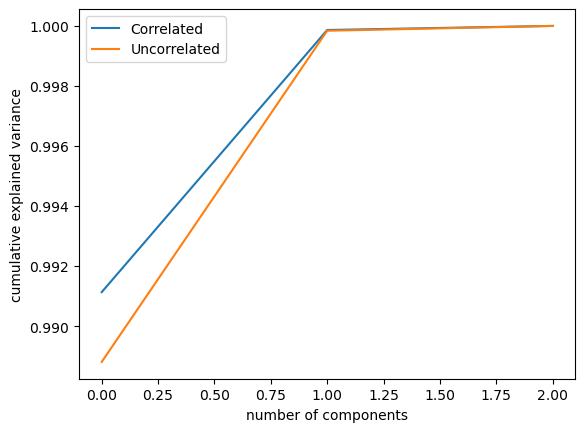

In [25]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Correlated Data
Xc, _, _, _, d = Xc_gen(5000, cor = True)
Xc = np.vstack((Xc,d))
[A_1, L, A_2, A_3, E, P, d] = Xc
columns = ['A_1', 'L', 'A_2', 'A_3', 'E', 'P', 'd']
Xc = Xc.T
dfX = pd.DataFrame(Xc, columns = columns)
pca = PCA(n_components=3)
pca_df = pca.fit_transform(dfX)

# Uncorrelated Data

Xc, _, _, _, d = Xc_gen(5000, cor = False)
Xc = np.vstack((Xc,d))
[A_1, L, A_2, A_3, E, P, d] = Xc
columns = ['A_1', 'L', 'A_2', 'A_3', 'E', 'P', 'd']
Xc = Xc.T
dfX = pd.DataFrame(Xc, columns = columns)
pca2 = PCA(n_components=3)
pca_df = pca2.fit_transform(dfX)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(['Correlated', 'Uncorrelated'])
plt.show()

## Task 4 - Design a meta-model [T4]

- T4.1 Referring to T1.3, use the generated LDBs (i.e. the collection $\mathcal{S}:=\left\lbrace \mathbf{X}^{(t)},y^{(t)}\right\rbrace_{t=1,...,N}$ with $\mathbf{X}=\left[A_1,A_2,A_3,E,L,P\right]^T$ and $y=d$, computed via Equation 1) to conceive a metamodel $\tilde{y}=m(\mathbf{X})$ (ANN, others...) to predict the displacement of node 2 $d$.

- T4.2 How is the predictive performance affected in time, given that $P(t)$ is a random field with triangular auto-correlation (T1.3)? Can you adapt your metamodel to all time-steps?

- T4.3 Compute the following metrics :
$$RMSE = \sqrt{\frac{1}{N}\sum_{t=1}^N\left(d^{(t)}-\tilde{d}^{(t)}\right)^2}$$
$$R^2 = 1-\frac{\sum_{t=1}^N\left(d^{(t)}-\tilde{d}^{(t)}\right)^2}{\sum_{t=1}^N\left(d^{(t)}-\bar{d}\right)^2}$$
$$\epsilon_m = \frac{1}{N}\sum_{t=1}^N 100\frac{\left(d^{(t)}-\tilde{d}^{(t)}\right)}{d^{(t)}}$$

with $\bar{d} = \frac{1}{N}\sum_{t=1}^N \tilde{d}^{(t)}$ 

## REFERENCES

[1] Roy, A. & Chakraborty, S. _Support vector regression based metamodel by sequential adaptive sampling for reliability analysis of structures_, Reliability Engineering & System Safety 200, Elsevier, 106948, 2020 

In [42]:
import requests
import numpy as np
import scipy
import pandas as pd
import sklearn as skl

import scikitplot as skplt
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.colors import ListedColormap

%matplotlib inline 
# This is required only for notebooks

Epoch 0, Loss: 0.0009888325266554422, Score: 0.5822562540094611
Epoch 10, Loss: 0.0004947505727963418, Score: 0.6456375256880253
Epoch 20, Loss: 0.0003694894751719998, Score: 0.6595618413063995
Epoch 30, Loss: 0.000331663037521396, Score: 0.6300106995407453
Epoch 40, Loss: 0.00031705836147864405, Score: 0.5901484045473044
Epoch 50, Loss: 0.00031092538905879195, Score: 0.6411870059188141
Epoch 60, Loss: 0.00029699138109931045, Score: 0.5568294494130045
Epoch 70, Loss: 0.0002902888156491299, Score: 0.6580250761964122
Epoch 80, Loss: 0.00028406115181972487, Score: 0.6347446690097125
Epoch 90, Loss: 0.0002760345041659879, Score: 0.6703039860019437
Epoch 100, Loss: 0.00027227157296978363, Score: 0.6694363751181994
Epoch 110, Loss: 0.0002650272514903532, Score: 0.6705684543816086
Epoch 120, Loss: 0.00025674003917207236, Score: 0.6764032673273659
Epoch 130, Loss: 0.0002538182954951017, Score: 0.6414075074482327
Epoch 140, Loss: 0.00024476359115574594, Score: 0.6715197087818447
Epoch 150, Loss

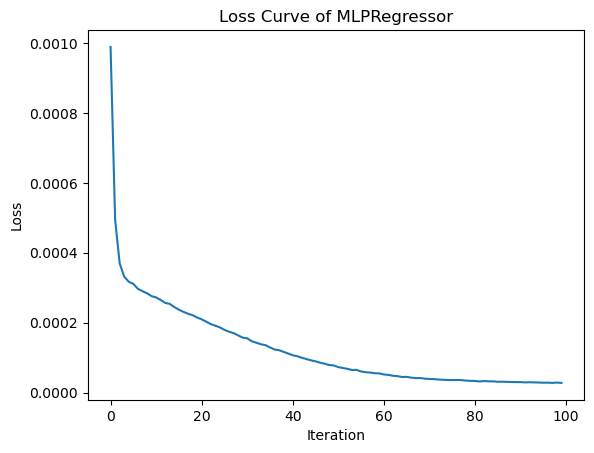

R-squared score: 0.6786145612872857
R-squared score from Sklearn Metrics: 0.6848114313279685
RMSE: 0.006388299976122449
RMSE from Sklearn Metrics: 0.006388299976122449
epsilon: -0.7318470730067682


,Predicted,Original
0,0.082631,0.077645
1,0.080642,0.090611
2,0.090895,0.088506
3,0.074630,0.071362
4,0.075205,0.076263


In [112]:
'''Model of fitting function for MLP classifier'''

"""
        Fit the model to the data
        
        Args:
            X (np.ndarray): features
            y (np.array): target labels
            
        Returns:
            obj: the MLPClassifierWrapper object
            
See: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
"""
import matplotlib.pyplot as plt

Np = 10000
Xc, _, _, _, d = Xc_gen(Np, cor = True)
Xc = StandardScaler().fit_transform(Xc)
Xc = Xc.T

X_train, X_test, d_train, d_test = train_test_split(Xc, d, test_size=0.2)

dmodel = MLPRegressor(hidden_layer_sizes=(1000, 500, 250, 500), max_iter = 1000,
                      activation = 'relu',
                      solver = 'adam',
                      learning_rate_init=0.0003,
                      batch_size=64)

# Use enumerate with a custom step size
best_score = -np.inf # Initialize best score
for epoch in range(0, 1000, 10): # Iterate over epochs with a step size of 10
    dmodel.partial_fit(X_train, d_train) # Train model on current batch of data
    score = dmodel.score(X_test, d_test) # Evaluate model on test data
    print(f"Epoch {epoch}, Loss: {dmodel.loss_}, Score: {score}") # Print epoch number, loss value and score
    if score > best_score: # Update best score if current score is better
        best_score = score

# Plot loss curve after training
plt.plot(dmodel.loss_curve_) # Plot loss values at each iteration
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve of MLPRegressor")
plt.show()

d_pred = dmodel.predict(X_test)

R = 1- (np.sum((d_pred-d_test)**2)/(np.sum((d_test-np.mean(d_test)))))
R = 1 - ((np.sum((d_pred - d_test)**2))/((np.sum((d_test - np.mean(d_pred))**2))))
print("R-squared score:", R)
print("R-squared score from Sklearn Metrics:", best_score)


mseM = np.sqrt(np.sum((d_pred-d_test)**2)/d_test.shape[0])
print("RMSE:", (mseM))
print("RMSE from Sklearn Metrics:", (np.sqrt(mse(d_pred,d_test))))

e=(np.sum(100*(d_pred-d_test)/d_test))/d_test.shape[0]
print("epsilon:", (e))

pred=np.vstack((d_pred,d_test)).T
predDF=pd.DataFrame(pred , columns=['Predicted', 'Original'])
predDF.head()